READ ME Step by step:
1. To run the program for the first time it will ask for Username and Key to use Kaggle API. You can find them in "kaggle.json" file
2. You might need to install necessary libraries to run the program
3. "Run All" button runs the program based on "Rice_Image_Dataset"
4. To process "Animals10" dataset you will need to run the second codeblock downloading specified dataset.

In [79]:
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import numpy as np
import gc
import os
import tensorflow as tf
import random
import opendatasets as od
from tensorflow.python.ops.gen_experimental_dataset_ops import non_serializable_dataset_eager_fallback

The code block below downloads and applies "Animals10" dataset

In [80]:
filename = "animals10/raw-img" #change the filename to specified directory
if not os.path.exists(filename): #checks whether the folder exists or not
    print("Downloading the dataset...")
    od.download("https://www.kaggle.com/datasets/alessiocorrado99/animals10") #dataset download
else: #shows the message if dataset is already downloaded
    print("Dataset file already exists.")

Dataset file already exists.


The code block below download and applies "Rice_Image_Dataset"

In [73]:
filename = "rice-image-dataset/Rice_Image_Dataset" #change the filename to specified directory
if not os.path.exists(filename): #checks whether the folder exists or not
    print("Downloading the dataset...")
    od.download("https://www.kaggle.com/datasets/muratkokludataset/rice-image-dataset?select=Rice_Image_Dataset") #dataset download
else: #shows the message if dataset is already downloaded
    print("Dataset file already exists.")

Dataset file already exists.


The bottom code block shows categories and initial resized image before preprocessing steps

Categories: ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']


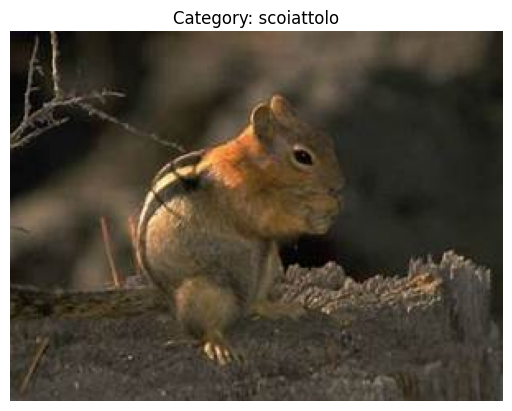

In [81]:
categories = [folder for folder in os.listdir(filename) if os.path.isdir(os.path.join(filename, folder))] #categories in the dataset

print("Categories:", categories) #print the categories

random_category = random.choice(categories) #randomising categories and images to show pictures in their original condition
path = os.path.join(filename, random_category)
random_image = random.choice(os.listdir(path)) #choosing random image from the dataset

img = cv2.imread(os.path.join(path, random_image))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img) #displaying images
plt.axis('off')
plt.title(f"Category: {random_category}") #specifies category
plt.show()

The following image processing techniques is the combination of the most flexible and effective pre-processing techniques.
Selected order of pre-processing techniques allows the program to extract valuable details for the CNN and make the model work faster by removing unnecessary information from the datasets of images.

In [82]:
def image_preprocessing(img):
    img = cv2.GaussianBlur(img, (3, 3), 0) #Gaussian Blur
    img_blurred = cv2.medianBlur(img, 3) #Medial Blur
    img_gray = cv2.cvtColor(img_blurred, cv2.COLOR_BGR2GRAY) #Converting to Grayscale
    resized = cv2.resize(img_gray, (128,128)) #Resizing and stretching images
    normalized = resized/255.0 #Normalizing images
    sobel_x = cv2.Sobel(normalized, cv2.CV_64F, 1, 0, ksize=3)  #Sobel edge detection for X axis
    sobel_y = cv2.Sobel(normalized, cv2.CV_64F, 0, 1, ksize=3)  #Sobel edge detection for Y axis
    final_image = cv2.magnitude(sobel_x, sobel_y) #Sobel edge detection application
    return final_image

Previously applied advanced Image Processing techniques resulting in the worst performance:
- Histogram Equalisation
- Background Removal
- Padding instead of stretching

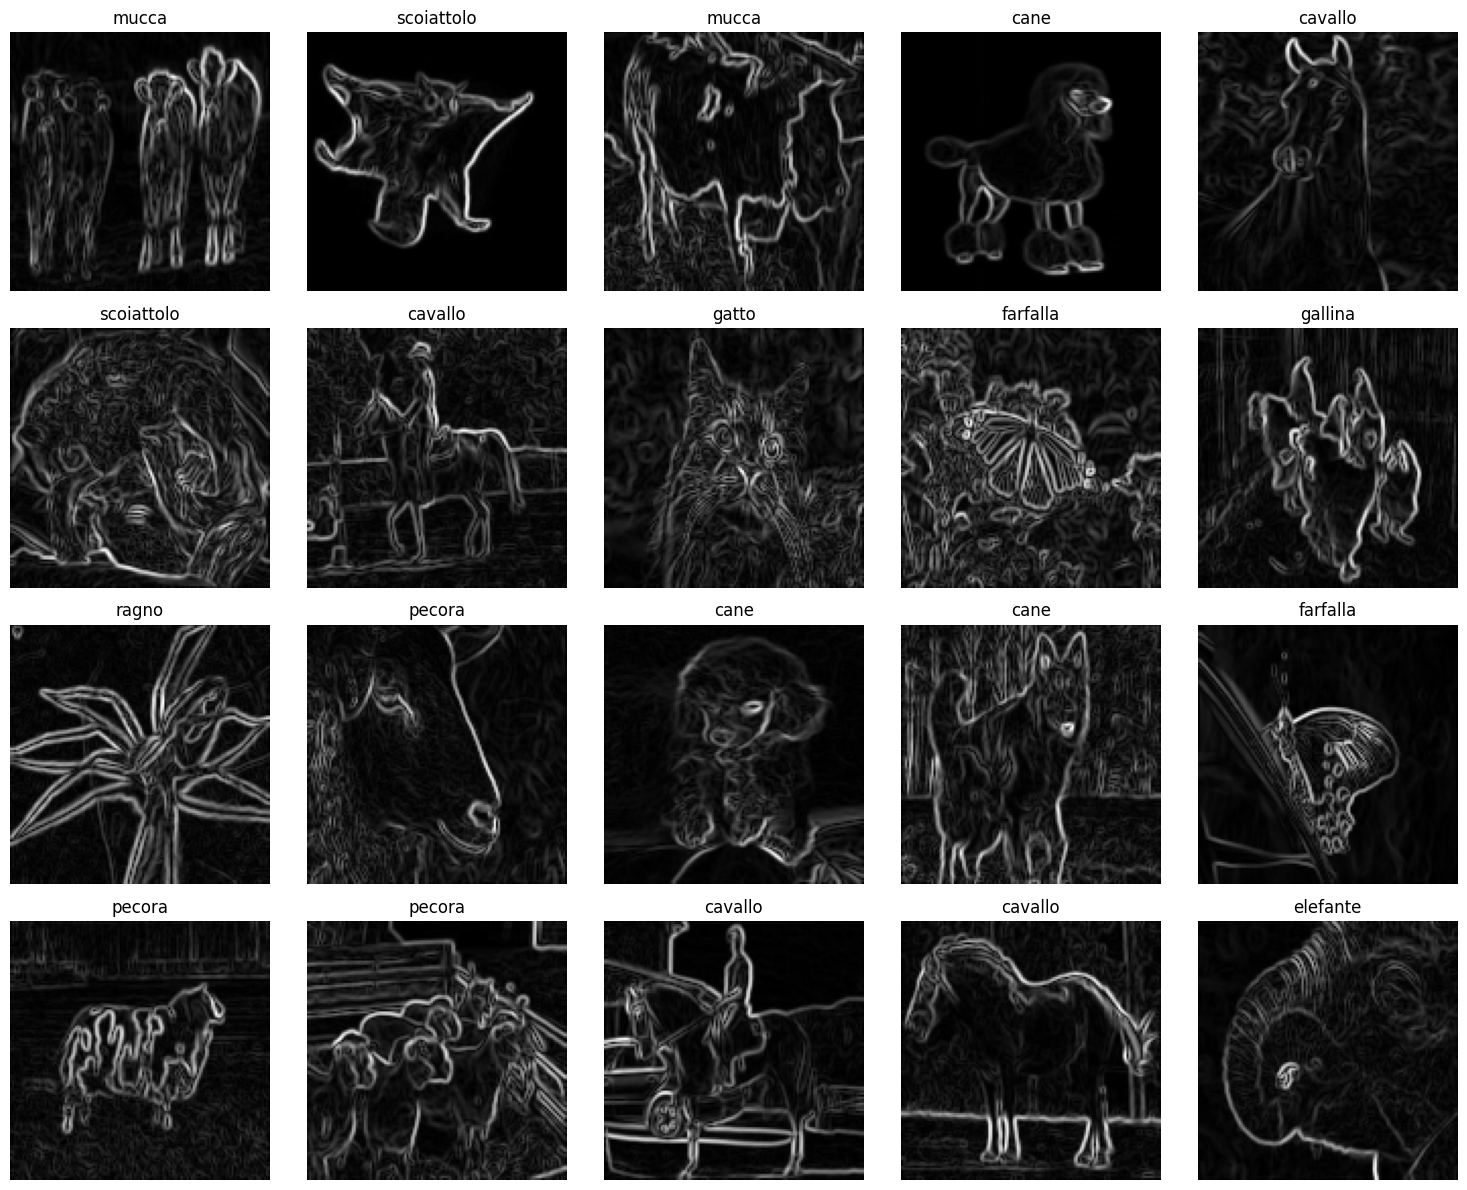

62261

In [83]:
dataset = []
for cl in categories:
    cls_num = categories.index(cl)
    path = os.path.join(filename, cl)
    for img in os.listdir(path):
        try:
            img = cv2.imread(os.path.join(path, img))
            preprocessed_image = image_preprocessing(img) #Image preprocessing
            if preprocessed_image is not None:
                dataset.append([preprocessed_image, cls_num])  #Adding images and their corresponding labels to the dataset
        except Exception as e:
            print(f"Error processing image: {e}")

random.shuffle(dataset) #Shuffling the dataset

num_display = min(20, len(dataset)) #Display first 20 images of the shuffled dataset
num_rows = (num_display + 4) // 5
plt.figure(figsize=(15, num_rows * 3))
for i, (img, cls_num) in enumerate(dataset[:num_display]):
    plt.subplot(num_rows, 5, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(categories[cls_num])
    plt.axis('off')
plt.tight_layout()
plt.show()
gc.collect()

Images length: 26179
Labels length: 26179


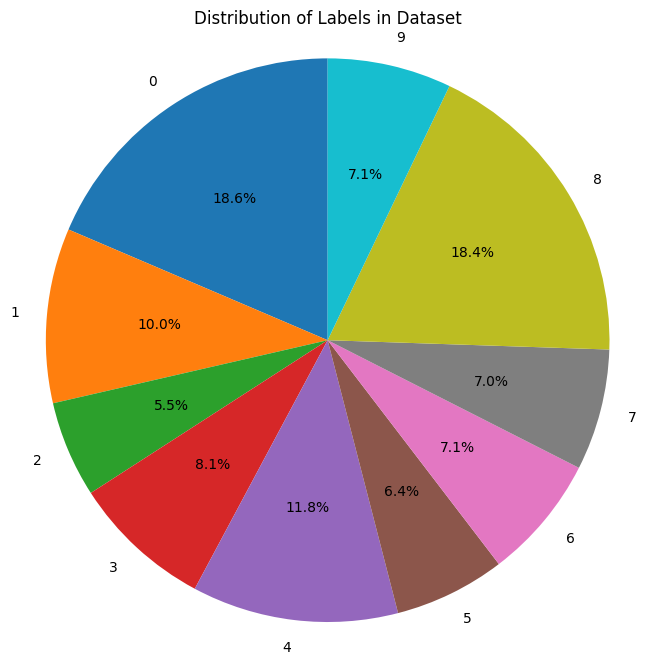

In [84]:
x = [] #The new dataset for images
y = [] #The new dataset for labels

for idx, (pic, label) in enumerate(dataset):
    resized_pic = cv2.resize(pic, (128, 128))
    x.append(resized_pic)
    y.append(label)

x = np.array(x)/255.0
y = np.array(y)

x_train_val, x_test, y_train_val, y_test = train_test_split(x, y, test_size=0.1, random_state=0) #90% of data for training + validation and 10% for testing
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=0.1, random_state=0) #10% of the remaining 90% for validation and 80% for training

print(f"Images length: {len(x)}")
print(f"Labels length: {len(y)}")

unique_labels, label_counts = np.unique(y, return_counts=True)

# Plot the pie chart
plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=unique_labels, autopct='%1.1f%%', startangle=90, colors=plt.cm.tab10.colors[:len(unique_labels)])
plt.title("Distribution of Labels in Dataset")
plt.axis("equal")  # Equal aspect ratio ensures the pie is drawn as a circle
plt.show()

C:\Users\bprid\AppData\Local\Temp\ipykernel_12896\1010608199.py:3: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(CustomConv2D, self).__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ custom_conv2d_9 (CustomConv2D)  │ (None, 128, 128, 3)    │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ custom_conv2d_10 (CustomConv2D) │ (None, 64, 64, 5)      │           140 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 32, 32, 5)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ custom_conv2d_11 (CustomConv2D) │ (None, 32, 32, 4)      │           184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 16, 16, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 16, 16, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,844 (518.92 KB)

 Trainable params: 132,844 (518.92 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
663/663 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.2344 - loss: 2.1573 - val_accuracy: 0.3471 - val_loss: 1.8838
Epoch 2/20
663/663 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.3481 - loss: 1.9010 - val_accuracy: 0.3704 - val_loss: 1.7960
Epoch 3/20
663/663 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.3846 - loss: 1.7918 - val_accuracy: 0.4039 - val_loss: 1.7407
Epoch 4/20
663/663 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.3969 - loss: 1.7481 - val_accuracy: 0.4103 - val_loss: 1.7105
Epoch 5/20
663/663 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.4177 - loss: 1.6808 - val_accuracy: 0.4132 - val_loss: 1.6837
Epoch 6/20
663/663 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.4342 - loss: 1.6423 - val_accuracy: 0.4298 - val_loss: 1.6616
Epoch 7/20
663/663 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.4462 - loss: 1.6082 - val_accuracy: 0.4294 - val_loss: 1.6325
Epoch 8/20
663/663 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.4538 - loss: 1.5758 - val_acc

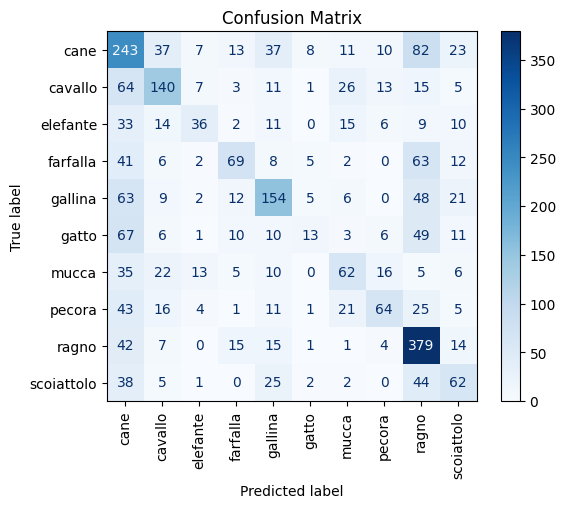

In [85]:
class CustomConv2D(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_size, kernel_initializer=None, padding="valid", activation=None, **kwargs):
        super(CustomConv2D, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.padding = padding
        self.activation = tf.keras.activations.get(activation)
        self.kernel_initializer = kernel_initializer

    def build(self, input_shape):
        kernel_shape = (*self.kernel_size, input_shape[-1], self.filters)
        if self.kernel_initializer is not None:
            self.kernel = self.add_weight(name="kernel",
                                          shape=kernel_shape,
                                          initializer=tf.constant_initializer(self.kernel_initializer),
                                          trainable=True)
        else:
            self.kernel = self.add_weight(name="kernel",
                                          shape=kernel_shape,
                                          initializer="glorot_uniform",
                                          trainable=True)


        #Initialize biases for each filter
        self.bias = self.add_weight(name="bias",
                                    shape=(self.filters,),
                                    initializer="zeros",
                                    trainable=True)

    def call(self, inputs):
        #Perform the convolution using multiple filters
        output = tf.nn.conv2d(inputs, self.kernel, strides=1, padding=self.padding.upper())
        #Add bias and apply the activation function, if specified
        output = tf.nn.bias_add(output, self.bias)
        if self.activation is not None:
            output = self.activation(output)
        return output

#Filters

sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
sobel_y = np.array([[-1, -2, -1],[ 0,  0,  0],[ 1,  2,  1]])
sharpening_filter = np.array([[ 0, -1,  0],[-1,  5, -1],[ 0, -1,  0]])

#Stack the filters for the first layer
predefined_kernels = np.stack([sobel_x, sobel_y, sharpening_filter], axis=-1)
predefined_kernels = np.expand_dims(predefined_kernels, axis=-2)  #Shape (3, 3, 1, 3)

gaussian_filter = np.array([[1, 2, 1], [2, 4, 2], [1, 2, 1]]) / 16
laplacian_filter = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])
emboss_filter = np.array([[-2, -1, 0], [-1, 1, 1], [0, 1, 2]])
box_blur = np.array([[1, 1, 1], [1, 1, 1], [1, 1, 1]]) / 9
diagonal_edge_filter = np.array([[2, -1, 0], [-1, 0, 1], [0, 1, -2]])
horizontal_edge_filter = np.array([[-1, -1, -1], [2, 2, 2], [-1, -1, -1]])
vertical_edge_filter = np.array([[-1, 2, -1], [-1, 2, -1], [-1, 2, -1]])

#Stack filters for the second layer
second_layer_kernels = np.stack(
    [gaussian_filter, laplacian_filter, emboss_filter, box_blur, diagonal_edge_filter], axis=-1
)
second_layer_kernels = np.expand_dims(second_layer_kernels, axis=-2)  #Shape (3, 3, 1, 5)

#Stack filters for the third layer
third_layer_kernels = np.stack(
    [sobel_x, sobel_y, horizontal_edge_filter, vertical_edge_filter], axis=-1
)
third_layer_kernels = np.expand_dims(third_layer_kernels, axis=-2)  #Shape (3, 3, 1, 4)

def adapt_filters(filters, input_depth):
    return np.tile(filters, (1, 1, input_depth, 1))  #Tile along the input depth axis

#Adjust filters for the second layer
second_layer_kernels = adapt_filters(second_layer_kernels, input_depth=3)  #Now (3, 3, 3, 5)

#Adjust filters for the third layer
third_layer_kernels = adapt_filters(third_layer_kernels, input_depth=5)  #Now (3, 3, 5, 4)

model = tf.keras.Sequential([
    #First layer
    CustomConv2D(filters=3, kernel_size=(3, 3), kernel_initializer=predefined_kernels, padding="same", activation="relu", input_shape=(128, 128, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),

    #Second layer
    CustomConv2D(filters=5, kernel_size=(3, 3), kernel_initializer=second_layer_kernels, padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D((2, 2)),

    #Third layer
    CustomConv2D(filters=4, kernel_size=(3, 3), kernel_initializer=third_layer_kernels, padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D((2, 2)),

    #Dropout for regularization
    tf.keras.layers.Dropout(0.25),

    #Flatten and fully connected layers
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.5),  #Dropout for fully connected layers
    tf.keras.layers.Dense(10, activation="softmax")  #Output layer
])

#Compile the model
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

model.summary()

model.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val))

#Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_acc}")
print(f"Test loss: {test_loss}")

#Make prediction on a test data
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, target_names=categories))

conf_matrix = confusion_matrix(y_test, y_pred_classes)
print("\nConfusion Matrix:")
print(conf_matrix)

#Heatmap of confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=categories)
disp.plot(cmap="Blues", xticks_rotation='vertical')
plt.title("Confusion Matrix")
plt.show()